# README

This notebook is intended to serve as a test site for code related to experimenting with the ECCO bird data and simulated drone data. 

The notebook is organized by sections as follows:
<ol type="I">
    <li><b>General:</b> code meant to be used across all of the sections (e.g., imports, common constants, helper functions, etc.).
    <li><b>Preprocessing:</b> anything having to do with preprocessing the datasets (e.g., dropping columns, reformatting fields, etc.).
    <li><b>Principal Component Analysis:</b> dedicated to analyzing data with PCA.
    <li><b>Comparing Classifiers:</b>: testing different classifiers and comparing for accuracy. 
</ol>
These sections are meant to be (more or less) independent of each other. For example, <b>Principal Component Analysis</b> doesn't need to be run before <b>Comparing Classifiers</b>. You can choose which preprocessing cells to run depending on your needs.


# I. General

### Imports

In [22]:
import pickle
import uuid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns

from datetime import datetime
from sklearn import metrics, svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Constants

In [2]:
# ecco fields deemed not important by aaron
NI_ECCO = ['User Edit Time', 'Type', 'Associated UUID', 'Note', 'Combat ID', 
           'Creator', 'Editor', 'AZ', 'Range', '2525', 'Closest Distance', 
           'Course', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type', 
           'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks']

# fields that only have one or two unique values:
# Source Name:  ['RPS82-90deg' 'ctcve']
# Source Class: ['RADAR']
# Source LID:   [21. 49.]
# Closest Time: [0.]
REPEAT_ECCO = ['Source Name', 'Source Class', 'Source LID', 'Closest Time']

# all other ecco fields (aside from position, velocity, heading)
OTHER_ECCO = ['Name', 'Create Time', 'Object ID', 'Origin Position (lat)',
              'Origin Position (lon)', 'Origin Position (alt MSL)', 'Radar Cross Section',
              'Source ID', 'Deleted', 'Deleted Time']

# the ecco fields related to time
TIME_COLS = ['Create Time', 'Update Time', 'Deleted Time']

# mapping from ecco to simulated
ECCO_SIMU_MAP = {
    'Update Time': 'UpdateTime',
    'Range To Contact': 'Range',
    'Bearing To Contact': 'AZ',
    'EL': 'EL',
    'Position (lat)': 'Position_lat_',
    'Position (lon)': 'Position_lon_',
    'Position (alt MSL)': 'Position_altMSL_',
    'Speed': 'Speed',
    'Radial Velocity': 'RadialVelocity'
}

# mapping numerical label to string label
BIO_IDX = 0
MM_INDEX = 1
LABEL_MAP = {
    BIO_IDX: 'Biological',
    MM_INDEX: 'Man-made'
}


### Helper Functions

In [3]:
# prints a summary of each dataframe passed in
# - dfs: a list of pandas dataframes
def printInfo(dfs):
    for df in dfs:
        print(df.info())
        print('\n======================================================\n')

# re-formats the time columns in ecco
# time_str: a time value from ecco (formatted as a string)
def formatTime(time_str):
    # convert the time (a string) to a datetime
    time_obj = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    return time_obj

# compares a set of predictions to true labels and prints accuracy
def printAccuracy(y_pred, y_true):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    print(f'accuracy = {100 * accuracy}')

# compares a set of predictions to true labels and prints F1 score
def printF1(y_pred, y_true):
    f1 = metrics.f1_score(y_true, y_pred)
    print(f'f1 = {f1}')

### Load ECCO and Simulated Datasets

In [4]:
# load ecco dataset
df_ecco = pd.read_csv('../data/raw/ecco.csv')
df_ecco.name = 'ecco.csv'

# load simulated dataset
li = []
for i in range(2,22):
    df = pd.read_csv(f'../data/raw/simulatedDroneData{i}.csv')
    li.append(df)

df_simu = pd.concat(li, axis=0, ignore_index=True)

# display a summary of the fields for each dataset
printInfo([df_ecco, df_simu])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17587 entries, 0 to 17586
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   UUID                       9553 non-null   object 
 1   Name                       9553 non-null   object 
 2   Create Time                9553 non-null   object 
 3   Update Time                9553 non-null   object 
 4   User Edit Time             62 non-null     object 
 5   Type                       9553 non-null   object 
 6   Associated UUID            9553 non-null   object 
 7   Note                       0 non-null      float64
 8   Source Name                9553 non-null   object 
 9   Source Class               9553 non-null   object 
 10  Source LID                 9553 non-null   float64
 11  Combat ID                  9553 non-null   object 
 12  Object ID                  9553 non-null   object 
 13  Range To Contact           9553 non-null   flo

/var/folders/sx/0gyr6z3573gdm1mnzzc8vw980000gn/T/ipykernel_84726/4030215448.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,11,12,26,34,35,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ecco = pd.read_csv('../data/raw/ecco.csv')


# II. Preprocessing

### Drop Rows and Columns from ECCO

In [5]:
# drop non-important features from ecco dataset
DROP_ECCO = NI_ECCO + REPEAT_ECCO
print(f'dropping the following fields:\n{DROP_ECCO}...\n')
df_ecco = df_ecco.drop(columns=DROP_ECCO)

# display a summary of the fields for each dataset
printInfo([df_ecco])

# drop all rows with nan
print(f'rows before dropping nan: {len(df_ecco)}')
df_ecco = df_ecco.dropna()
print(f'rows after dropping nan: {len(df_ecco)}')


dropping the following fields:
['User Edit Time', 'Type', 'Associated UUID', 'Note', 'Combat ID', 'Creator', 'Editor', 'AZ', 'Range', '2525', 'Closest Distance', 'Course', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type', 'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks', 'Source Name', 'Source Class', 'Source LID', 'Closest Time']...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17587 entries, 0 to 17586
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   UUID                       9553 non-null   object 
 1   Name                       9553 non-null   object 
 2   Create Time                9553 non-null   object 
 3   Update Time                9553 non-null   object 
 4   Object ID                  9553 non-null   object 
 5   Range To Contact           9553 non-null   float64
 6   Bearing To Contact         9553 non-null   float64
 7   EL                         9551 n

### Reformat Time Columns in ECCO

In [6]:
# display the first few values of each time column before formatting
print('Time columns before reformatting:')
for tc in TIME_COLS:
    print(f'{tc}: {type(df_ecco[tc][0])}')
print(df_ecco[TIME_COLS].head())

# reformat each of the time columns (one-by-one)
for tc in TIME_COLS:
    df_ecco[tc] = df_ecco[tc].apply(formatTime)

# display the first few values of each time column after formatting
print('\n======================================================\n')
print('Time columns after reformatting:')
for tc in TIME_COLS:
    print(f'{tc}: {type(df_ecco[tc][0])}')
print(df_ecco[TIME_COLS].head())


Time columns before reformatting:
Create Time: <class 'str'>
Update Time: <class 'str'>
Deleted Time: <class 'str'>
                   Create Time                  Update Time  \
0  2022-06-16T17:52:01.898832Z  2022-06-16T17:54:45.692026Z   
1  2022-06-16T17:53:00.654140Z  2022-06-16T17:54:45.692520Z   
2  2022-06-16T17:52:01.898832Z  2022-06-16T17:54:45.725468Z   
3  2022-06-16T17:52:01.898832Z  2022-06-16T17:54:45.829479Z   
4  2022-06-16T17:52:06.462136Z  2022-06-16T17:54:45.840658Z   

                  Deleted Time  
0  2022-06-16T18:00:30.308269Z  
1  2022-06-16T17:58:09.980982Z  
2  2022-06-16T18:00:30.308269Z  
3  2022-06-16T18:00:30.308269Z  
4  2022-06-16T17:58:16.230071Z  


Time columns after reformatting:
Create Time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Update Time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Deleted Time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
                 Create Time                Update Time  \
0 2022-06-16 17:52:0

### Match ECCO Fields to Simulated Fields

In [7]:
# create UUIDs for the simulated data
track_IDs = [None] * len(df_simu)

for i in range(len(df_simu)):
    id_ = str(uuid.uuid1())
    if i % 10 == 0:
        id_ = str(uuid.uuid1())
    track_IDs[i] = id_

df_simu['UUID'] = track_IDs


# drop all remaining columns from ecco that aren't in simu
df_ecco = df_ecco.drop(columns=OTHER_ECCO)

# rename all the ecco columns to match simu
df_ecco = df_ecco.rename(columns=ECCO_SIMU_MAP, errors='raise')

# reorder df_ecco columns to match up with df_simu
df_ecco = df_ecco.reindex(columns=df_simu.columns)

# compare the column names of ecco and simu
same = df_ecco.columns.to_list() == df_simu.columns.to_list()
print(f'are the ecco and simu column names equal? {same}')
print(df_simu.columns.to_list())


are the ecco and simu column names equal? True
['UUID', 'Update Time', 'Range To Contact', 'Bearing To Contact', 'EL', 'Position (lat)', 'Position (lon)', 'Position (alt MSL)', 'Speed', 'Radial Velocity']


### Combine ECCO and Simulated into Dataset X and Labels y

In [9]:
# add labels to ecco and simu
df_ecco['Label'] = BIO_IDX
df_simu['Label'] = MM_INDEX

# combine ecco and simu into one dataset
X = pd.concat([df_ecco, df_simu])

# create the labels using the label column of X
y = X['Label']

# drop the label column from X
X = X.drop(columns='Label')

# for now, also drop times
X = X.drop(columns='Update Time')


### Scale the Data

In [9]:
# we want to scale all features except for UUID
uuid_idx = X.columns.get_loc('UUID')
X_cols = X.columns.delete(uuid_idx)

# the scaled columns should have mean 0 and std 1
scaler = StandardScaler()
scaler.fit(X[X_cols])

scaled_X = pd.DataFrame(scaler.transform(X[X_cols]))


# III. Principal Component Analysis

### Perform PCA 

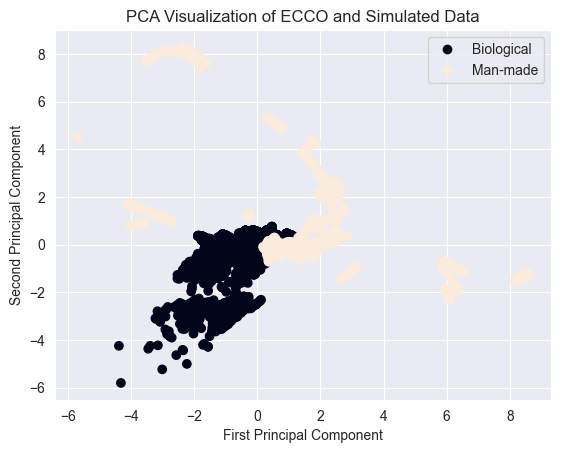

<Axes: >

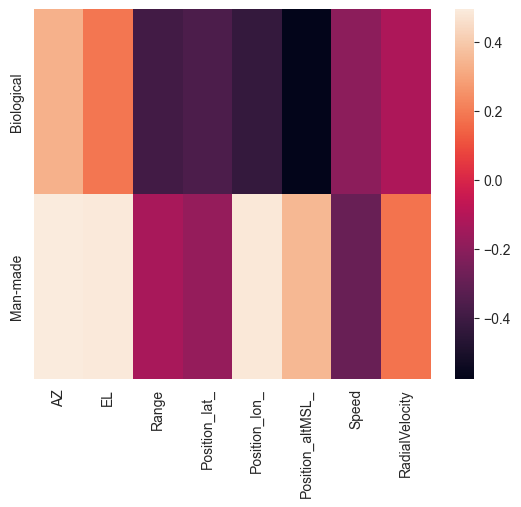

In [10]:
# perform PCA on the scaled data
pca = PCA(n_components=2)
pca.fit(scaled_X)
X_pca = pca.transform(scaled_X)

# plot the first PC vs the second PC
plot = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization of ECCO and Simulated Data')
plt.legend(handles=plot.legend_elements()[0], labels=[LABEL_MAP[0], LABEL_MAP[1]])
plt.show()

components = pd.DataFrame(pca.components_, columns=X_cols)
sns.heatmap(components, yticklabels=[LABEL_MAP[0], LABEL_MAP[1]])


# IV. Comparing Classifiers

### Classification: Attempt 1
This first round of classifiers is trained on the raw track data, without extracting any derivative data. Therefore, it makes predictions on a purely sample-by-sample basis. This is intended to give us a feel for how these classifier perform in comparison each other.

Random forest and SVM were chosen as these are two main traditional ML approaches we've come across in our research that have been used for this problem. 

In [10]:

# split the data into distinct training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['UUID']), y, test_size=0.2)

# define the classifiers
rf = RandomForestClassifier()
sv = svm.SVC()

# fit random forest and svm on training data, isolation forest on ecco data
rf.fit(X_train, y_train)
sv.fit(X_train, y_train)

# use the trained models to generate predictions
rf_pred = rf.predict(X_test)
sv_pred = rf.predict(X_test)

In [11]:
# report the accuracy of the models
pp = pprint.PrettyPrinter(width=100)

print('CLASSIFIER EVALUATION: NO FEATURE ENGINEERING\n')
print('Here we compare the performance of\nsupport vector machine to random\nforest, using the following features:\n')
pp.pprint(list(X_test.columns))
print(' ')

print('random forest:')
printAccuracy(rf_pred, y_test)
printF1(rf_pred, y_test)
print(' ')
print('svm:')
printAccuracy(sv_pred, y_test)
printF1(sv_pred, y_test)

CLASSIFIER EVALUATION: NO FEATURE ENGINEERING

Here we compare the performance of
support vector machine to random
forest, using the following features:

['AZ',
 'EL',
 'Range',
 'Position_lat_',
 'Position_lon_',
 'Position_altMSL_',
 'Speed',
 'RadialVelocity']
 
random forest:
accuracy = 100.0
f1 = 1.0
 
svm:
accuracy = 100.0
f1 = 1.0


number of trees in rf: 100


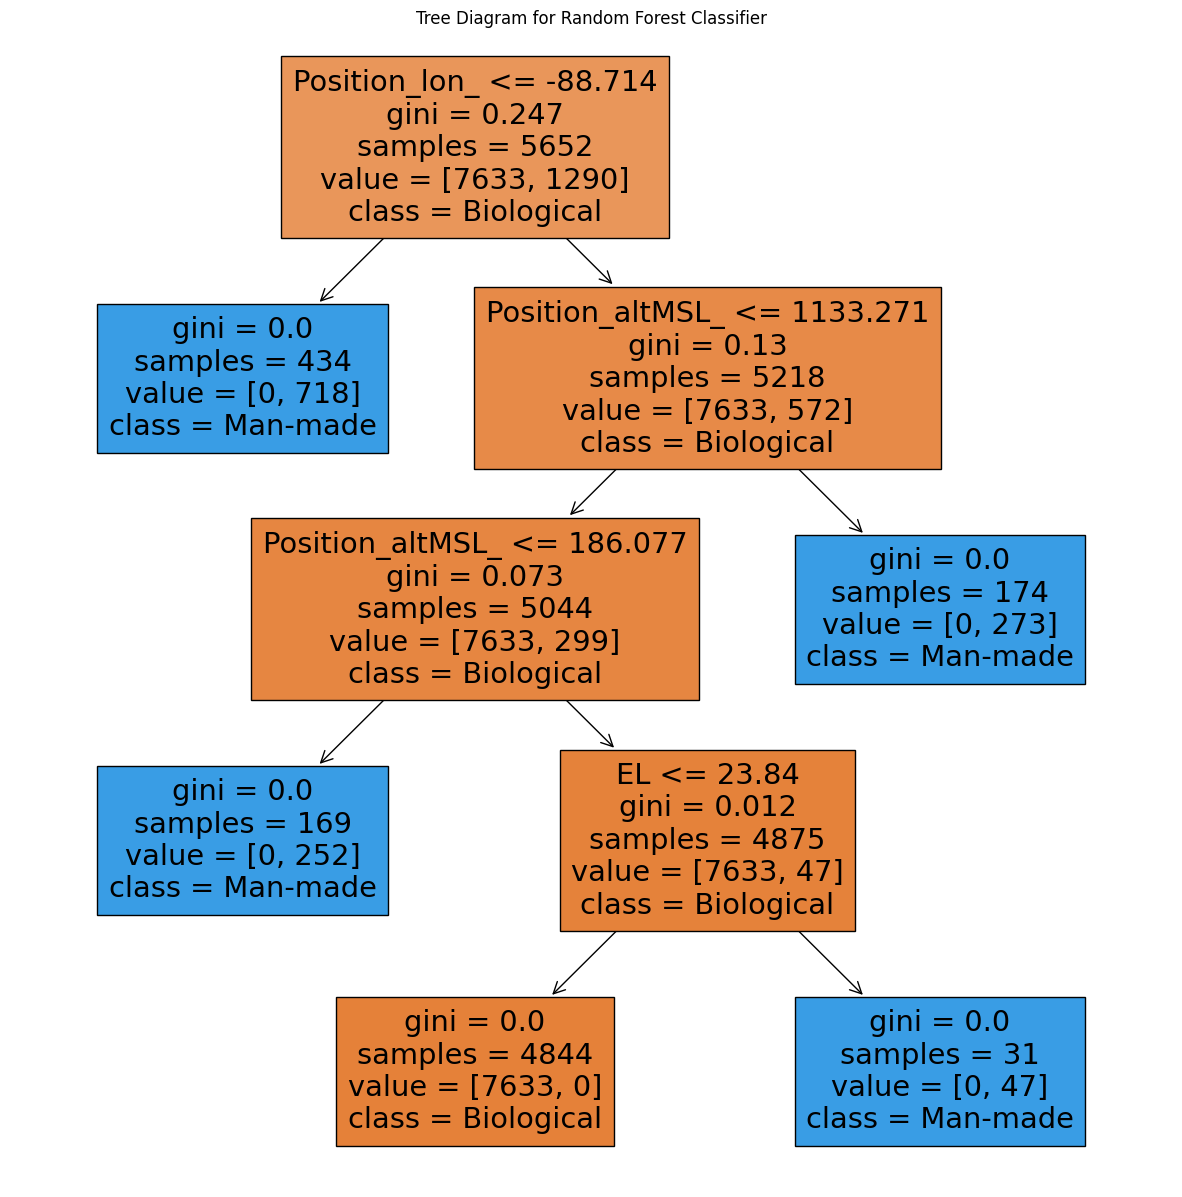

In [12]:
# visualize the first three random forest trees
print(f'number of trees in rf: {len(rf.estimators_)}')
plt.figure(figsize=(15, 15))

tree.plot_tree(rf.estimators_[0],
            feature_names = X.columns, 
            class_names=['Biological', 'Man-made'],
            filled = True)
plt.title('Tree Diagram for Random Forest Classifier')
plt.show()


### Classification: Attempt 2
Here we train the classifiers on information derived from the raw data, but not the raw data itself. The derived information is as follows:
<ul>
    <li><b>Average Speed:</b> the average speed of the track.
    <li><b>Standard Deviation of Speed:</b> the standard deviation of the speeds of the track.
    <li><b>Standard Deviation of Heading:</b> the standard deviation of the headings of the track.
    <li><b>Maneuverability Factor:</b> the average speed devided by standard deviation of heading.
    <li><b>Oscillation Factor:</b> 
</ul>

These statistics are based on the research presented in the following paper:
<br>J. Liu, Q. Y. Xu and W. S. Chen, 
<br>"Classification of Bird and Drone Targets Based on Motion Characteristics and Random Forest Model Using Surveillance Radar Data," 
<br>in IEEE Access, vol. 9, pp. 160135-160144, 2021, doi: 10.1109/ACCESS.2021.3130231.

In [9]:
def calculateHeading(df):
    delta_x = df['Position_lat_'] - df['Position_lat_'].shift(-1)
    delta_y = df['Position_lon_'] - df['Position_lon_'].shift(-1)   
    return np.arctan2(delta_y, delta_x)

def calculateHeadingStd(df):
    heading = calculateHeading(df)
    return np.std(heading)

def calculateOscFactor(df):
    heading = calculateHeading(df)
    theta = heading.shift(1) - heading

    O = theta.copy(deep=True)
    O[theta > 0.5] = 1
    O[theta < -0.5] = -1
    O[abs(theta) <= 0.5] = 0

    w = O.copy(deep=True)
    osc_number = 1
    for j in range(1, O.shape[0]-1):
        w[j] = osc_number

In [10]:
X['Label'] = y
X_grouped = X.groupby('UUID')

avg_speed = X_grouped['Speed'].mean()
std_speed = X_grouped['Speed'].std()
std_heading = X_grouped.apply(calculateHeadingStd)  
mav_factor = avg_speed / std_heading

X_new = pd.DataFrame({
    'avg_speed': avg_speed,
    'std_speed': std_speed,
    'std_heading': std_heading,
    'mav_factor': mav_factor
})

X_new.replace([np.nan], 0, inplace=True)
X_new.replace([np.inf], 99999, inplace=True)
X_new.replace([-np.inf], -99999, inplace=True)

y_new = X_grouped['Label'].first()

In [11]:
# split the data into distinct training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2)

# define the classifiers
rf = RandomForestClassifier()
sv = svm.SVC(probability=True)

# fit random forest and svm on training data, isolation forest on ecco data
rf.fit(X_train, y_train)
sv.fit(X_train, y_train)

# use the trained models to generate predictions
rf_pred = rf.predict(X_test)
sv_pred = sv.predict(X_test)

# get the confidence levels of each model
rf_confidence_pair = rf.predict_proba(X_test)
sv_confidence_pair = sv.predict_proba(X_test)

In [12]:
# report the accuracy of the models
pp = pprint.PrettyPrinter(width=100)

print('CLASSIFIER EVALUATION: NO FEATURE ENGINEERING\n')
print('Here we compare the performance of\nsupport vector machine to random\nforest, using the following features:\n')
pp.pprint(list(X_test.columns))
print(' ')

print('random forest:')
printAccuracy(rf_pred, y_test)
printF1(rf_pred, y_test)

rf_confidence = [max(pair) for pair in rf_confidence_pair]
avg_rf_confidence = np.mean(rf_confidence)
med_rf_confidence = np.median(rf_confidence)

print(f'average confidence level: {avg_rf_confidence}')
print(f'median confidence level: {med_rf_confidence}')

print(' ')

print('svm:')
printAccuracy(sv_pred, y_test)
printF1(sv_pred, y_test)

sv_confidence = [max(pair) for pair in sv_confidence_pair]
avg_sv_confidence = np.mean(sv_confidence)
med_sv_confidence = np.median(sv_confidence)

print(f'average confidence level: {avg_sv_confidence}')
print(f'median confidence level: {med_sv_confidence}')

CLASSIFIER EVALUATION: NO FEATURE ENGINEERING

Here we compare the performance of
support vector machine to random
forest, using the following features:

['avg_speed', 'std_speed', 'std_heading', 'mav_factor']
 
random forest:
accuracy = 100.0
f1 = 1.0
average confidence level: 0.9987278106508876
median confidence level: 1.0
 
svm:
accuracy = 95.56213017751479
f1 = 0.9772382397572079
average confidence level: 0.9839239093249333
median confidence level: 0.98926119605283


number of trees in rf: 100


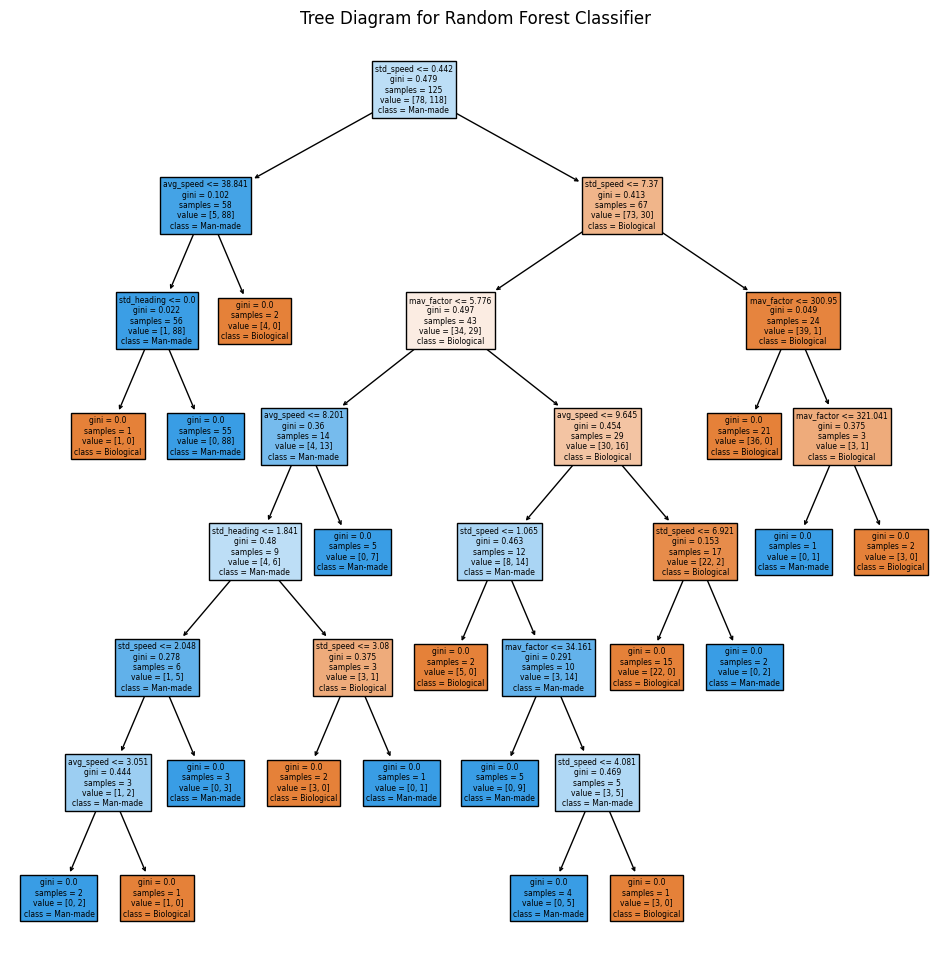

In [20]:
# visualize the first three random forest trees
print(f'number of trees in rf: {len(rf.estimators_)}')
plt.figure(figsize=(12, 12))

tree.plot_tree(rf.estimators_[0],
            feature_names = X_new.columns, 
            class_names=['Biological', 'Man-made'],
            filled = True)
plt.title('Tree Diagram for Random Forest Classifier')
plt.show()


In [16]:
X = pd.read_csv("../data/combined/combined_labeled.csv")

y = X['Label']
X = X.drop(columns=["Label", "Update Time"])

X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['UUID']), y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [17]:
printAccuracy(rf_pred, y_test)

accuracy = 100.0


In [21]:
# save the model to disk
filename = '../models/initial_noFF.sav'
pickle.dump(rf, open(filename, 'wb'))
# 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, y_test)
# print(result)